In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer

#metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn import metrics

import random
random.seed(48)

sns.set_palette(sns.color_palette('Dark2'))


In [73]:
# import training and testing data, which was cleaned in notebook_1

model_train_df = pd.read_csv('../data/transformed_data/model_train_df.csv')
model_test_df = pd.read_csv('../data/transformed_data/model_test_df.csv')

In [74]:
# a function for scoring and pulling model metrics

def model_metrics(some_lr, scaled=False):

    if scaled:
        train_r2 = some_lr.score(X_train_sc, y_train)
        test_r2 = some_lr.score(X_test_sc, y_test)
        
    else:
        train_r2 = some_lr.score(X_train, y_train)
        test_r2 = some_lr.score(X_test, y_test)
    preds = some_lr.predict(X)
    resids_mean = (y - preds).mean()
    mae = metrics.mean_absolute_error(y, preds)
    resids = resids = y - preds
    rss = (resids ** 2).sum()
    mse = metrics.mean_squared_error(y, preds)
    rmse = np.sqrt(metrics.mean_squared_error(y, preds))
    cvs = cross_val_score(some_lr, X, y, cv=5).mean()
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds)

    final_dict={'Train R2 Score': train_r2,
                'Test R2 Score' : test_r2,
                'Mean of Residuals': resids_mean,
               'Mean Absolute Error': mae,
               'Residual Sum of Squares': rss,
               'Mean Squared Error': mse,
               'Root Mean Squared Error': rmse,
               'cross_val_score': cvs,
               'f1': f1}
    return final_dict, class_report

In [75]:
X = model_train_df.drop(columns = ['target'])
y = model_train_df['target']

X_test_data = model_test_df.drop(columns = ['target'])
y_test_data = model_test_df['target']

In [76]:
y.value_counts(normalize=True)

0    0.937942
1    0.062058
Name: target, dtype: float64

In [77]:
y_test_data.value_counts(normalize=True)

0    0.937942
1    0.062058
Name: target, dtype: float64

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y, random_state=48)

In [79]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [80]:
model_metrics(nb)

({'Train R2 Score': 0.7099404132093334,
  'Test R2 Score': 0.7070114769708816,
  'Mean of Residuals': -0.2723796254065947,
  'Mean Absolute Error': 0.29035249069029634,
  'Residual Sum of Squares': 57932,
  'Mean Squared Error': 0.29035249069029634,
  'Root Mean Squared Error': 0.5388436607127306,
  'cross_val_score': 0.7100534937527551,
  'f1': 0.2677031980786247},
 '              precision    recall  f1-score   support\n\n           0       0.99      0.70      0.82    187141\n           1       0.16      0.86      0.27     12382\n\n    accuracy                           0.71    199523\n   macro avg       0.57      0.78      0.54    199523\nweighted avg       0.94      0.71      0.78    199523\n')

In [81]:
logreg = LogisticRegression(max_iter=100_000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [82]:
model_metrics(logreg)

({'Train R2 Score': 0.9451188951383861,
  'Test R2 Score': 0.9445196211096076,
  'Mean of Residuals': 0.03940397848869554,
  'Mean Absolute Error': 0.054941034366965215,
  'Residual Sum of Squares': 10962,
  'Mean Squared Error': 0.054941034366965215,
  'Root Mean Squared Error': 0.23439503912618376,
  'cross_val_score': 0.9450238747408013,
  'f1': 0.3514376996805112},
 '              precision    recall  f1-score   support\n\n           0       0.95      0.99      0.97    187141\n           1       0.66      0.24      0.35     12382\n\n    accuracy                           0.95    199523\n   macro avg       0.80      0.62      0.66    199523\nweighted avg       0.93      0.95      0.93    199523\n')

In [83]:
logreg.score(X_test_data, y_test_data)

0.9450589656330348

In [84]:
coef = list(logreg.coef_)
features = list(X.columns)
income_coef = pd.DataFrame(zip(features, coef[0]), columns=['Feature', 'Coefficient'],index=features).drop(columns='Feature').sort_values(by='Coefficient', ascending=False)
income_coef

,Coefficient
veterans_benefits,0.559045
stock_dividends,0.543852
age,0.527804
num_employed,0.100315
weeks_worked,0.051261
occupation_major,0.039828
education,0.034443
employment_status,0.026645
household_summary,0.023859
industry_detailed,0.005430


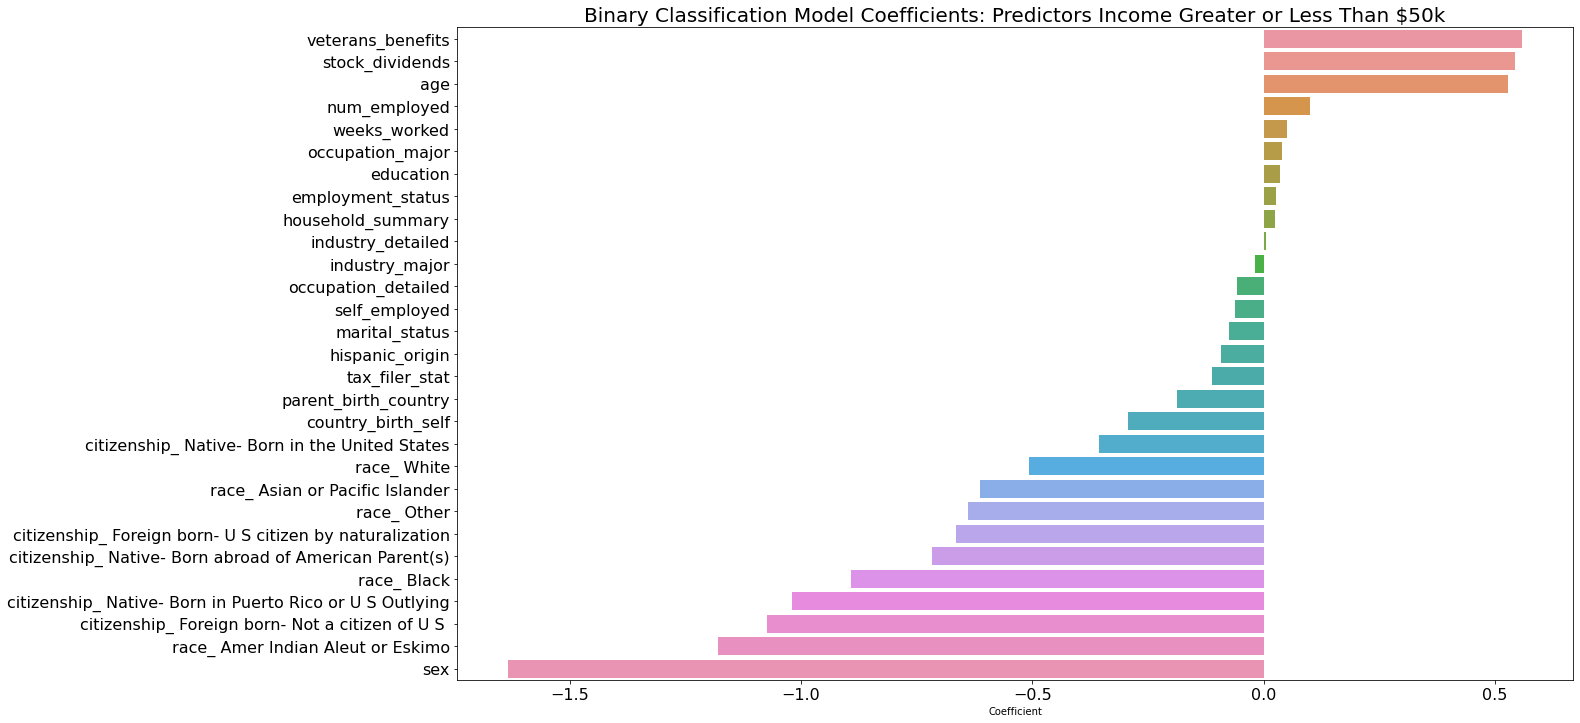

In [85]:
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y = income_coef.index, x=income_coef['Coefficient'], ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Binary Classification Model Coefficients: Predictors Income Greater or Less Than $50k', fontsize=20);

<Figure size 1440x1440 with 0 Axes>

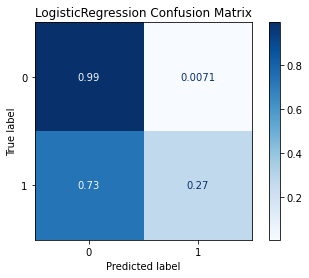

In [64]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', normalize='true')
plt.title('LogisticRegression Confusion Matrix');

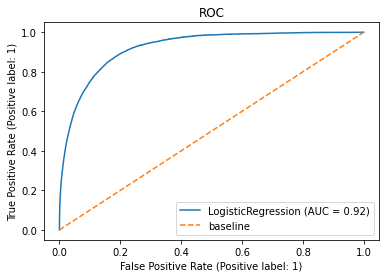

In [14]:
#ROC plot code is from General Assembly lesson 4.05.
plot_roc_curve(logreg, X, y)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

In [45]:
rf = RandomForestClassifier(ccp_alpha=.01)
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.01)

In [46]:
model_metrics(rf)

/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/TJohn/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


({'Train R2 Score': 0.9379393301507348,
  'Test R2 Score': 0.937952637514096,
  'Mean of Residuals': 0.06205800834991455,
  'Mean Absolute Error': 0.06205800834991455,
  'Residual Sum of Squares': 12382,
  'Mean Squared Error': 0.06205800834991455,
  'Root Mean Squared Error': 0.24911444829618884,
  'cross_val_score': 0.9379419917412115,
  'f1': 0.0},
 '              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97    187141\n           1       0.00      0.00      0.00     12382\n\n    accuracy                           0.94    199523\n   macro avg       0.47      0.50      0.48    199523\nweighted avg       0.88      0.94      0.91    199523\n')

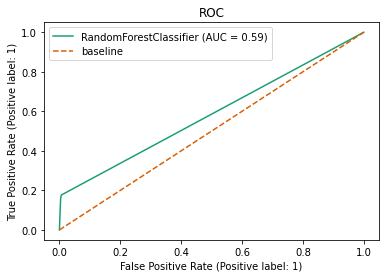

In [47]:
#ROC plot code is from General Assembly lesson 4.05.
plot_roc_curve(rf, X, y)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

In [17]:
rf_params = {
    'criterion': ['gini','entropy'],
    'min_samples_split': [2, 4],
    'n_estimators': [3, 5],
    'class_weight': ['balanced', 'balanced_subsample'],
    'ccp_alpha': [.0001, .001, .01, .1]

}

rf_gridsearch = GridSearchCV(RandomForestClassifier(), 
                              rf_params, 
                              cv=5, 
                              verbose=1)

In [18]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01, 0.1],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4], 'n_estimators': [3, 5]},
             verbose=1)

In [19]:
rf_gridsearch.best_params_

{'ccp_alpha': 0.0001,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'min_samples_split': 2,
 'n_estimators': 5}

In [20]:
rf_gridsearch.best_score_

0.9039895245758061

In [50]:
rf = RandomForestClassifier(ccp_alpha=0.0001)
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001)

In [51]:
model_metrics(rf)

({'Train R2 Score': 0.9510894761242467,
  'Test R2 Score': 0.9515098358601679,
  'Mean of Residuals': 0.041288473008124375,
  'Mean Absolute Error': 0.04882645108583973,
  'Residual Sum of Squares': 9742,
  'Mean Squared Error': 0.04882645108583973,
  'Root Mean Squared Error': 0.2209670814529615,
  'cross_val_score': 0.9504768813904153,
  'f1': 0.41050465932470054},
 '              precision    recall  f1-score   support\n\n           0       0.95      1.00      0.97    187141\n           1       0.82      0.27      0.41     12382\n\n    accuracy                           0.95    199523\n   macro avg       0.89      0.63      0.69    199523\nweighted avg       0.95      0.95      0.94    199523\n')

In [52]:
rf.score(X_test_data, y_test_data)

0.9511735489141603

In [23]:
estimators = [('knn', KNeighborsClassifier(p=1)),
              ('tree', DecisionTreeClassifier(random_state=42, ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3))]

stacks = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=7)

stacks.fit(X_train, y_train)


StackingClassifier(cv=7,
                   estimators=[('knn', KNeighborsClassifier(p=1)),
                               ('tree',
                                DecisionTreeClassifier(ccp_alpha=0.001,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier())

In [28]:
stacks.score(X_test_data, y_test_data)

0.9556742831653493

In [65]:
#transforming data in preparation for KNN model
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [69]:
knn = KNeighborsClassifier(p=1)
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(p=1)

In [70]:
knn.score(X_test, y_test)

0.8716483736781436

In [71]:
knn.score(X_train, y_train)

0.8688867850977334